In [3]:
# make sure kaggle 1.5.12 is installed and api key is configured (~/.kaggle/kaggle.json), if not then:
# !pip install --upgrade --force-reinstall --no-deps kaggle

# later:
# !kaggle competitions download -c petfinder-pawpularity-score
# !unzip -q petfinder-pawpularity-score.zip -d input

100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 5.84MB/s]


In [1]:
import pandas as pd

data_dir = "input" #if using the code above
#data_dir = "~/Downloads/petfinder-pawpularity-score" #comment it out if using the code above

df = pd.read_csv(f"{data_dir}/train.csv")
df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [2]:
from sklearn import linear_model, ensemble, svm, neighbors, gaussian_process, cross_decomposition, tree, neural_network, model_selection

import warnings
warnings.filterwarnings('ignore')


X = df.drop(["Pawpularity","Id"], axis=1)
y = df["Pawpularity"]


models = [
    linear_model.LinearRegression,
    linear_model.BayesianRidge,
    linear_model.ElasticNet,
    linear_model.SGDRegressor,
    ensemble.RandomForestRegressor,
    ensemble.AdaBoostRegressor,
    ensemble.GradientBoostingRegressor,
    ensemble.BaggingRegressor,
    svm.SVR,
    neighbors.KNeighborsRegressor,
    neighbors.RadiusNeighborsRegressor,
    gaussian_process.GaussianProcessRegressor,
    cross_decomposition.PLSRegression,
    tree.DecisionTreeRegressor,
    neural_network.MLPRegressor
]

losses = dict()

for model_cls in models:
    model = model_cls()
    scores = model_selection.cross_val_score(model, X, y, scoring="neg_root_mean_squared_error") * -1
    print(f"{model_cls.__name__}: {scores.round(4)}")
    losses[model_cls.__name__] = scores

result = pd.DataFrame.from_dict(data=losses, orient="index")


LinearRegression: [20.7124 20.8424 20.8812 20.1258 20.426 ]
BayesianRidge: [20.7034 20.8227 20.915  20.1187 20.4009]
ElasticNet: [20.702  20.8087 20.915  20.1187 20.4009]
SGDRegressor: [20.7289 20.8374 20.8915 20.1306 20.4556]
RandomForestRegressor: [20.8987 20.9826 21.0042 20.3225 20.6237]
AdaBoostRegressor: [21.0905 21.174  21.141  20.4481 20.9536]
GradientBoostingRegressor: [20.7273 20.8792 20.8871 20.1601 20.4318]
BaggingRegressor: [20.9621 20.9959 21.0784 20.3127 20.6135]
SVR: [21.2024 21.3595 21.4271 20.71   20.9424]
KNeighborsRegressor: [23.5003 23.7901 22.7031 22.298  22.6859]
RadiusNeighborsRegressor: [20.7063 20.7912 20.9256 20.1516 20.3703]
GaussianProcessRegressor: [21.0147 21.0553 21.1175 20.4349 20.847 ]
PLSRegression: [20.7139 20.8286 20.8995 20.1233 20.4233]
DecisionTreeRegressor: [20.9265 21.0564 21.084  20.4299 20.8004]
MLPRegressor: [20.7087 20.8235 20.8398 20.1559 20.3975]


In [3]:
result["mean"] = result.apply(lambda row: row.mean(), axis=1)
result["min"] = result.apply(lambda row: row.min(), axis=1)
result["max"] = result.apply(lambda row: row.max(), axis=1)
result.sort_values(by="mean").round(4)

,0,1,2,3,4,mean,min,max
MLPRegressor,20.7087,20.8235,20.8398,20.1559,20.3975,20.5851,20.1559,20.8398
RadiusNeighborsRegressor,20.7063,20.7912,20.9256,20.1516,20.3703,20.5890,20.1516,20.9256
ElasticNet,20.7020,20.8087,20.9150,20.1187,20.4009,20.5890,20.1187,20.9150
BayesianRidge,20.7034,20.8227,20.9150,20.1187,20.4009,20.5921,20.1187,20.9150
LinearRegression,20.7124,20.8424,20.8812,20.1258,20.4260,20.5976,20.1258,20.8812
PLSRegression,20.7139,20.8286,20.8995,20.1233,20.4233,20.5977,20.1233,20.8995
SGDRegressor,20.7289,20.8374,20.8915,20.1306,20.4556,20.6088,20.1306,20.8915
GradientBoostingRegressor,20.7273,20.8792,20.8871,20.1601,20.4318,20.6171,20.1601,20.8871
RandomForestRegressor,20.8987,20.9826,21.0042,20.3225,20.6237,20.7663,20.3225,21.0042
BaggingRegressor,20.9621,20.9959,21.0784,20.3127,20.6135,20.7925,20.3127,21.0784


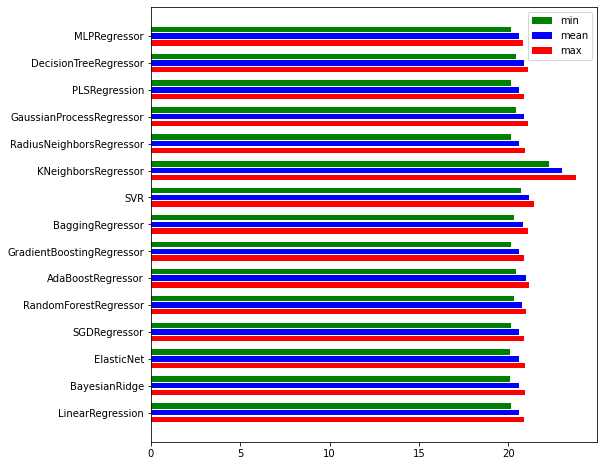

In [4]:
import matplotlib.pyplot as plt
import numpy as np
groups = np.arange(0, len(result.index))*4

plt.figure(figsize=(8,8))
plt.barh(groups+1, result["min"], color="green", label="min")
plt.barh(groups, result["mean"], color="blue", label="mean")
plt.barh(groups-1, result["max"], color="red", label="max")

plt.yticks(groups, result.index)
plt.legend()
plt.show()